In [7]:
import numpy as np

import pyabc
from pyabc import Distribution, RV, ABCSMC

std = 0.02
ts = np.linspace(0, 30, 10)
x0 = np.array([1, 0])

def x(p, x0, ts):
    """
    States via analytic solution of ODE.
    Returns an array of shape n_x * n_t.
    """
    p0 = p.get('p0', 0.06)
    p1 = p.get('p1', 0.08)
    n_t = len(ts)
    sol = np.zeros((2, n_t))
    for ix, t in enumerate(ts):
        e = np.exp(- (p0 + p1) * t)
        A = 1 / (- p0 - p1) * np.array([[- p1 - p0 * e, - p1 + p1 * e],
                                        [- p0 + p0 * e, - p0 - p1 * e]])
        sol[:, ix] = np.dot(A, x0).flatten()
    return sol

def model(p):
    y = x(p, x0, ts)
    y += std * np.random.normal(size=y.shape)
    return {'y0': y[0,:].flatten(), 'y1': y[1,-1]}

# true model parameter
refval = {'p0': 0.06, 'p1': 0.08}

# observed summary statistics
obs = model(refval)

limits = {'p0': (0, 0.4), 'p1': (0, 0.4)}
prior = Distribution(
            **{key: RV('uniform', bounds[0], bounds[1])
               for key, bounds in limits.items()})

distances = [
    pyabc.PNormDistance(),
    pyabc.AdaptivePNormDistance(adaptive=False, scale_function=pyabc.distance.median_absolute_deviation),
    pyabc.AdaptivePNormDistance(adaptive=True, scale_function=pyabc.distance.median_absolute_deviation),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=False, normalize_labels=False)),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=False)),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=True)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=False), adaptive=True),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=False, n_fit=4), adaptive=True),
    pyabc.PNormDistance(sumstat=pyabc.GPPredictorSumstat()),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat()),
    pyabc.PNormDistance(sumstat=pyabc.PredictorSumstat(predictor=pyabc.MLPPredictor())),
    pyabc.PNormDistance(sumstat=pyabc.PredictorSumstat(
        predictor=pyabc.ModelSelection(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor()]
        ),
        n_fit=1,
    )),pyabc.PNormDistance(sumstat=pyabc.PredictorSumstat(
        predictor=pyabc.ModelSelection(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor()]
        ),
        n_fit=4,
    )),
    pyabc.distance.InfoWeightedPNormDistance(predictor=pyabc.ModelSelection(
            predictors=[pyabc.LinearPredictor()]
        ),
        n_fit=1,
    ),
    pyabc.distance.InfoWeightedPNormDistance(predictor=pyabc.ModelSelection(
            predictors=[pyabc.LinearPredictor()]
        ),
        n_fit=4,
    ),
]

labels = [
    'Euclidean',
    'Calibrated Euclidean',
    'Adaptive Euclidean',
    'Learned linear nn',
    'Learned linear tn',
    'Learned linear tt',
    'Adaptive + LL tn',
    'Adaptive + LL tn n_fit=4',
    'GP',
    'Adaptive GP',
    'MLP',
    'Model selection',
    'Model selection n_fit=4',
    'Info weighted ms',
    'Info weighted ms n_fit=4',
]

def plot_history(history: pyabc.History, label: str):
    fig, ax = plt.subplots(1,2)
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=limits['p0'][0], xmax=limits['p0'][1], numx=300, refval=refval,
                                        x='p0', xname="$p_0$", ax=ax[0],
                                        label="PDF t={}".format(t))
        pyabc.visualization.plot_kde_1d(df, w, xmin=limits['p1'][0], xmax=limits['p1'][1], numx=300, refval=refval,
                                        x='p1', xname="$p_1$", ax=ax[1],
                                        label="PDF t={}".format(t))
    ax[1].axvline(0, color='k', linestyle='dashed', label="True value")
    ax[1].legend()
    ax[1].set_title(label)

In [8]:
hs = []

for distance, label in zip(distances, labels):
    print(label)
    abc = ABCSMC(model, prior, distance, population_size=500)
    abc.new(pyabc.create_sqlite_db_id(), obs)
    h = abc.run(max_total_nr_simulations=1e4)
    hs.append(h)

INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=211, start_time=2021-03-29 09:19:48.800127>
INFO:ABC:Calibration sample t=-1.


Euclidean


INFO:Epsilon:initial epsilon is 0.6377139442630119
INFO:ABC:t: 0, eps: 0.6377139442630119.
INFO:ABC:Acceptance rate: 500 / 955 = 5.2356e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 0.36220157611117776.
INFO:ABC:Acceptance rate: 500 / 933 = 5.3591e-01, ESS=4.7929e+02.
INFO:ABC:t: 2, eps: 0.2395640571148851.
INFO:ABC:Acceptance rate: 500 / 1039 = 4.8123e-01, ESS=4.8417e+02.
INFO:ABC:t: 3, eps: 0.20198047603128058.
INFO:ABC:Acceptance rate: 500 / 1015 = 4.9261e-01, ESS=4.8285e+02.
INFO:ABC:t: 4, eps: 0.1726211164601475.
INFO:ABC:Acceptance rate: 500 / 1123 = 4.4524e-01, ESS=4.5881e+02.
INFO:ABC:t: 5, eps: 0.14779451637612032.
INFO:ABC:Acceptance rate: 500 / 1160 = 4.3103e-01, ESS=4.4632e+02.
INFO:ABC:t: 6, eps: 0.1267762946482009.
INFO:ABC:Acceptance rate: 500 / 1275 = 3.9216e-01, ESS=4.4032e+02.
INFO:ABC:t: 7, eps: 0.11138643762850806.
INFO:ABC:Acceptance rate: 500 / 1302 = 3.8402e-01, ESS=3.5680e+02.
INFO:ABC:t: 8, eps: 0.09930481952269381.
INFO:ABC:Acceptance rate: 500 / 1766 = 2.8313e-01,

Calibrated Euclidean


INFO:Epsilon:initial epsilon is 4.554448971162226
INFO:ABC:t: 0, eps: 4.554448971162226.
INFO:ABC:Acceptance rate: 500 / 963 = 5.1921e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 2.7498428311597083.
INFO:ABC:Acceptance rate: 500 / 1094 = 4.5704e-01, ESS=4.8412e+02.
INFO:ABC:t: 2, eps: 2.082018543979259.
INFO:ABC:Acceptance rate: 500 / 1198 = 4.1736e-01, ESS=4.8373e+02.
INFO:ABC:t: 3, eps: 1.6880268011336161.
INFO:ABC:Acceptance rate: 500 / 1610 = 3.1056e-01, ESS=4.6664e+02.
INFO:ABC:t: 4, eps: 1.4271794625264622.
INFO:ABC:Acceptance rate: 500 / 2005 = 2.4938e-01, ESS=4.3012e+02.
INFO:ABC:t: 5, eps: 1.2259202261021274.
INFO:ABC:Acceptance rate: 500 / 2589 = 1.9312e-01, ESS=4.2298e+02.
INFO:ABC:t: 6, eps: 1.0558127143292264.
INFO:ABC:Acceptance rate: 500 / 3214 = 1.5557e-01, ESS=4.4336e+02.
INFO:pyabc.util:Stopping: total simulations budget.
INFO:History:Done <ABCSMC id=212, duration=0:00:21.856948, end_time=2021-03-29 09:20:37.081319>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO

Adaptive Euclidean


INFO:Epsilon:initial epsilon is 4.360462422202525
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 4.360462422202525.
INFO:ABC:Acceptance rate: 500 / 1011 = 4.9456e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 2.783010185766208.
INFO:ABC:Acceptance rate: 500 / 1080 = 4.6296e-01, ESS=4.7745e+02.
INFO:ABC:t: 2, eps: 3.154356411789615.
INFO:ABC:Acceptance rate: 500 / 1276 = 3.9185e-01, ESS=4.8138e+02.
INFO:ABC:t: 3, eps: 3.704001194672745.
INFO:ABC:Acceptance rate: 500 / 1265 = 3.9526e-01, ESS=4.6696e+02.
INFO:ABC:t: 4, eps: 5.16704397568224.
INFO:ABC:Acceptance rate: 500 / 1183 = 4.2265e-01, ESS=4.5158e+02.
INFO:ABC:t: 5, eps: 5.276004541042019.
INFO:ABC:Acceptance rate: 500 / 1350 = 3.7037e-01, ESS=4.0281e+02.
INFO:ABC:t: 6, eps: 5.037928299178877.
INFO:ABC:Acceptance rate: 500 / 1662 = 3.0084e-01, ESS=4.2528e+02.
INFO:ABC:t: 7, eps: 4.8605095659039526.
INFO:ABC:Acceptance rate: 500 / 2051 = 2.4378e-01, ESS=3.9667e+02.
INFO:pyabc.util:Stopping: total simulations bu

Learned linear nn


INFO:Predictor:Fitted LinearPredictor
INFO:Epsilon:initial epsilon is 0.20618910800554963
INFO:ABC:t: 0, eps: 0.20618910800554963.
INFO:ABC:Acceptance rate: 500 / 978 = 5.1125e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 0.1462804412603299.
INFO:ABC:Acceptance rate: 500 / 1110 = 4.5045e-01, ESS=4.8278e+02.
INFO:ABC:t: 2, eps: 0.10891956030353081.
INFO:ABC:Acceptance rate: 500 / 1191 = 4.1982e-01, ESS=4.5185e+02.
INFO:ABC:t: 3, eps: 0.08020637038330743.
INFO:ABC:Acceptance rate: 500 / 1310 = 3.8168e-01, ESS=4.7034e+02.
INFO:ABC:t: 4, eps: 0.05515069234223802.
INFO:ABC:Acceptance rate: 500 / 1266 = 3.9494e-01, ESS=4.1631e+02.
INFO:ABC:t: 5, eps: 0.03855031883791708.
INFO:ABC:Acceptance rate: 500 / 1414 = 3.5361e-01, ESS=3.4951e+02.
INFO:ABC:t: 6, eps: 0.02682268785741133.
INFO:ABC:Acceptance rate: 500 / 1917 = 2.6082e-01, ESS=3.7883e+02.
INFO:ABC:t: 7, eps: 0.01915174712254384.
INFO:ABC:Acceptance rate: 500 / 2784 = 1.7960e-01, ESS=3.1240e+02.
INFO:pyabc.util:Stopping: total simulations budg

Learned linear tn


INFO:Predictor:Fitted LinearPredictor
INFO:Epsilon:initial epsilon is 0.1953866099887475
INFO:ABC:t: 0, eps: 0.1953866099887475.
INFO:ABC:Acceptance rate: 500 / 1033 = 4.8403e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 0.1446515409497829.
INFO:ABC:Acceptance rate: 500 / 1031 = 4.8497e-01, ESS=4.9211e+02.
INFO:ABC:t: 2, eps: 0.1043841990600113.
INFO:ABC:Acceptance rate: 500 / 1133 = 4.4131e-01, ESS=4.7982e+02.
INFO:ABC:t: 3, eps: 0.07516846960281151.
INFO:ABC:Acceptance rate: 500 / 1118 = 4.4723e-01, ESS=4.6564e+02.
INFO:ABC:t: 4, eps: 0.05080448773570728.
INFO:ABC:Acceptance rate: 500 / 1299 = 3.8491e-01, ESS=4.3768e+02.
INFO:ABC:t: 5, eps: 0.03625061131477393.
INFO:ABC:Acceptance rate: 500 / 1441 = 3.4698e-01, ESS=4.4118e+02.
INFO:ABC:t: 6, eps: 0.025217633086968193.
INFO:ABC:Acceptance rate: 500 / 1765 = 2.8329e-01, ESS=4.3201e+02.
INFO:ABC:t: 7, eps: 0.017868870081547167.
INFO:ABC:Acceptance rate: 500 / 2534 = 1.9732e-01, ESS=4.2293e+02.
INFO:pyabc.util:Stopping: total simulations budg

Learned linear tt


INFO:Predictor:Fitted LinearPredictor
INFO:Epsilon:initial epsilon is 1.6193287144913788
INFO:ABC:t: 0, eps: 1.6193287144913788.
INFO:ABC:Acceptance rate: 500 / 1032 = 4.8450e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.1651618848766718.
INFO:ABC:Acceptance rate: 500 / 1016 = 4.9213e-01, ESS=4.8448e+02.
INFO:ABC:t: 2, eps: 0.8742298854026943.
INFO:ABC:Acceptance rate: 500 / 1163 = 4.2992e-01, ESS=4.7077e+02.
INFO:ABC:t: 3, eps: 0.6362198372323111.
INFO:ABC:Acceptance rate: 500 / 1315 = 3.8023e-01, ESS=4.5032e+02.
INFO:ABC:t: 4, eps: 0.4328304036080232.
INFO:ABC:Acceptance rate: 500 / 1420 = 3.5211e-01, ESS=4.4510e+02.
INFO:ABC:t: 5, eps: 0.3041903392847667.
INFO:ABC:Acceptance rate: 500 / 1634 = 3.0600e-01, ESS=3.8341e+02.
INFO:ABC:t: 6, eps: 0.20481209612071577.
INFO:ABC:Acceptance rate: 500 / 2351 = 2.1268e-01, ESS=3.9335e+02.
INFO:pyabc.util:Stopping: total simulations budget.
INFO:History:Done <ABCSMC id=216, duration=0:00:23.684135, end_time=2021-03-29 09:22:15.991852>
INFO:Sampler:

Adaptive + LL tn


INFO:Predictor:Fitted LinearPredictor
INFO:Epsilon:initial epsilon is 1.812836393695545
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.812836393695545.
INFO:ABC:Acceptance rate: 500 / 956 = 5.2301e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.362923190314599.
INFO:ABC:Acceptance rate: 500 / 1072 = 4.6642e-01, ESS=4.6656e+02.
INFO:ABC:t: 2, eps: 1.1955001286676226.
INFO:ABC:Acceptance rate: 500 / 1161 = 4.3066e-01, ESS=4.5956e+02.
INFO:ABC:t: 3, eps: 1.055010101585725.
INFO:ABC:Acceptance rate: 500 / 1219 = 4.1017e-01, ESS=4.7294e+02.
INFO:ABC:t: 4, eps: 0.8889331373669114.
INFO:ABC:Acceptance rate: 500 / 1302 = 3.8402e-01, ESS=4.4286e+02.
INFO:ABC:t: 5, eps: 0.7621152111371268.
INFO:ABC:Acceptance rate: 500 / 1656 = 3.0193e-01, ESS=2.3583e+02.
INFO:ABC:t: 6, eps: 0.6595783251749056.
INFO:ABC:Acceptance rate: 500 / 2169 = 2.3052e-01, ESS=4.1571e+02.
INFO:pyabc.util:Stopping: total simulations budget.
INFO:History:Done <ABCSMC id=217, duration=0:00:36.358040, 

Adaptive + LL tn n_fit=4


INFO:Predictor:Fitted LinearPredictor
INFO:Epsilon:initial epsilon is 1.9149525877914972
INFO:Population:Recording also rejected particles: True
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.9149525877914972.
INFO:ABC:Acceptance rate: 500 / 1085 = 4.6083e-01, ESS=5.0000e+02.
INFO:Predictor:Fitted LinearPredictor
INFO:ABC:t: 1, eps: 1.3239741351458938.
INFO:ABC:Acceptance rate: 500 / 1087 = 4.5998e-01, ESS=4.6918e+02.
INFO:Predictor:Fitted LinearPredictor
INFO:ABC:t: 2, eps: 1.1971830091073603.
INFO:ABC:Acceptance rate: 500 / 1228 = 4.0717e-01, ESS=4.5119e+02.
INFO:Predictor:Fitted LinearPredictor
INFO:ABC:t: 3, eps: 1.0634261477255562.
INFO:ABC:Acceptance rate: 500 / 1227 = 4.0750e-01, ESS=4.6388e+02.
INFO:ABC:t: 4, eps: 0.9794825345566219.
INFO:ABC:Acceptance rate: 500 / 1240 = 4.0323e-01, ESS=4.4058e+02.
INFO:ABC:t: 5, eps: 0.8557731563903056.
INFO:ABC:Acceptance rate: 500 / 1417 = 3.5286e-01, ESS=4.4423e+02.
INFO:ABC:t: 6, eps: 0.7134022891282725.
INF

GP


INFO:Predictor:Fitted GPPredictor
INFO:Epsilon:initial epsilon is 2.084161631678969
INFO:ABC:t: 0, eps: 2.084161631678969.
INFO:ABC:Acceptance rate: 500 / 954 = 5.2411e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.4819810720506965.
INFO:ABC:Acceptance rate: 500 / 1047 = 4.7755e-01, ESS=4.7431e+02.
INFO:ABC:t: 2, eps: 0.9823880040753923.
INFO:ABC:Acceptance rate: 500 / 1033 = 4.8403e-01, ESS=4.7018e+02.
INFO:ABC:t: 3, eps: 0.6021259152405466.
INFO:ABC:Acceptance rate: 500 / 1026 = 4.8733e-01, ESS=4.7451e+02.
INFO:ABC:t: 4, eps: 0.43314588316069175.
INFO:ABC:Acceptance rate: 500 / 1307 = 3.8256e-01, ESS=4.1625e+02.
INFO:ABC:t: 5, eps: 0.3006552427336484.
INFO:ABC:Acceptance rate: 500 / 1488 = 3.3602e-01, ESS=4.1803e+02.
INFO:ABC:t: 6, eps: 0.20255029596019844.
INFO:ABC:Acceptance rate: 500 / 2087 = 2.3958e-01, ESS=4.0092e+02.
INFO:ABC:t: 7, eps: 0.14093050699674747.
INFO:ABC:Acceptance rate: 500 / 2574 = 1.9425e-01, ESS=2.6498e+02.
INFO:pyabc.util:Stopping: total simulations budget.
INFO:Hi

Adaptive GP


INFO:Predictor:Fitted GPPredictor
INFO:Epsilon:initial epsilon is 2.0808790468388896
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 2.0808790468388896.
INFO:ABC:Acceptance rate: 500 / 1025 = 4.8780e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.3891804684604852.
INFO:ABC:Acceptance rate: 500 / 1059 = 4.7214e-01, ESS=4.7203e+02.
INFO:ABC:t: 2, eps: 1.04172626130742.
INFO:ABC:Acceptance rate: 500 / 1090 = 4.5872e-01, ESS=4.7357e+02.
INFO:ABC:t: 3, eps: 0.8664885436910136.
INFO:ABC:Acceptance rate: 500 / 1202 = 4.1597e-01, ESS=4.8324e+02.
INFO:ABC:t: 4, eps: 0.7885116201550173.
INFO:ABC:Acceptance rate: 500 / 1244 = 4.0193e-01, ESS=4.2809e+02.
INFO:ABC:t: 5, eps: 0.7238938551101335.
INFO:ABC:Acceptance rate: 500 / 1558 = 3.2092e-01, ESS=3.9882e+02.
INFO:ABC:t: 6, eps: 0.5967120714781116.
INFO:ABC:Acceptance rate: 500 / 1925 = 2.5974e-01, ESS=3.3199e+02.
INFO:ABC:t: 7, eps: 0.49317307621128037.
INFO:ABC:Acceptance rate: 500 / 2773 = 1.8031e-01, ESS=1.4133e+02.
INFO

MLP


INFO:Predictor:Fitted MLPPredictor
INFO:Epsilon:initial epsilon is 1.7541763193623
INFO:ABC:t: 0, eps: 1.7541763193623.
INFO:ABC:Acceptance rate: 500 / 1044 = 4.7893e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.0143255074182873.
INFO:ABC:Acceptance rate: 500 / 1170 = 4.2735e-01, ESS=4.6272e+02.
INFO:ABC:t: 2, eps: 0.668001433498757.
INFO:ABC:Acceptance rate: 500 / 1425 = 3.5088e-01, ESS=4.1042e+02.
INFO:ABC:t: 3, eps: 0.4481237993639834.
INFO:ABC:Acceptance rate: 500 / 1819 = 2.7488e-01, ESS=4.0520e+02.
INFO:ABC:t: 4, eps: 0.31233590615054907.
INFO:ABC:Acceptance rate: 500 / 2508 = 1.9936e-01, ESS=3.9757e+02.
INFO:ABC:t: 5, eps: 0.2293782271882674.
INFO:ABC:Acceptance rate: 500 / 3752 = 1.3326e-01, ESS=4.1943e+02.
INFO:pyabc.util:Stopping: total simulations budget.
INFO:History:Done <ABCSMC id=221, duration=0:00:38.852505, end_time=2021-03-29 09:25:10.855961>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INFO:History:Start <ABCSMC id=222, start_time=2021-03-29 09:25:10.920984>
INFO

Model selection


INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Score LinearPredictor: 3.01e+00
INFO:Predictor:Score GPPredictor: 1.99e+00
INFO:Predictor:Fitted GPPredictor
INFO:Epsilon:initial epsilon is 1.8941756454409364
INFO:ABC:t: 0, eps: 1.8941756454409364.
INFO:ABC:Acceptance rate: 500 / 983 = 5.0865e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 1.3174069713346819.
INFO:ABC:Acceptance rate: 500 / 1052 = 4.7529e-01, ESS=4.7301e+02.
INFO:ABC:t: 2, eps: 0.8495170621618408.
INFO:ABC:Acceptance rate: 500 / 953 = 5.2466e-01, ESS=4.7744e+02.
INFO:ABC:t: 3, eps: 0.5934546709473792.
INFO:ABC:Acceptance rate: 500 / 1173 = 4.2626e-01, ESS=4.5308e+02.
INFO:ABC:t: 4, eps: 0.43848466878255415

Model selection n_fit=4


INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Score LinearPredictor: 2.88e+00
INFO:Predictor:Score GPPredictor: 1.94e+00
INFO:Predictor:Fitted GPPredictor
INFO:Epsilon:initial epsilon is 1.8501880279054947
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.8501880279054947.
INFO:ABC:Acceptance rate: 500 / 1035 = 4.8309e-01, ESS=5.0000e+02.
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted GPPredictor
INFO:Predictor

Info weighted ms


INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Score LinearPredictor: 3.09e+00
INFO:Predictor:Fitted LinearPredictor
INFO:Epsilon:initial epsilon is 0.19063795775892897
INFO:ABC:t: 0, eps: 0.19063795775892897.
INFO:ABC:Acceptance rate: 500 / 992 = 5.0403e-01, ESS=5.0000e+02.
INFO:ABC:t: 1, eps: 0.10977983164320172.
INFO:ABC:Acceptance rate: 500 / 909 = 5.5006e-01, ESS=4.8188e+02.
INFO:ABC:t: 2, eps: 0.06523916373965226.
INFO:ABC:Acceptance rate: 500 / 1128 = 4.4326e-01, ESS=4.7921e+02.
INFO:ABC:t: 3, eps: 0.04828794473120673.
INFO:ABC:Acceptance rate: 500 / 1096 = 4.5620e-01, ESS=4.4517e+02.
INFO:ABC:t: 4, eps: 0.038429704903456305.
INFO:ABC:Acceptance rate: 500 / 1320 = 3.7879e-01, ESS=4.0894e+02.
INFO:ABC:t: 5, eps: 0.02931687569759811.
INFO:ABC:Acceptance rate: 500 / 1539 = 3.2489e-01, ESS=4.4845e+02.
INFO:ABC:t: 6, eps: 0.0221

Info weighted ms n_fit=4


INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Score LinearPredictor: 3.00e+00
INFO:Predictor:Fitted LinearPredictor
INFO:Epsilon:initial epsilon is 0.20064623835562825
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 0.20064623835562825.
INFO:ABC:Acceptance rate: 500 / 1062 = 4.7081e-01, ESS=5.0000e+02.
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Score LinearPredictor: 2.98e+00
INFO:Predictor:Fitted LinearPredictor
INFO:ABC:t: 1, eps: 0.11093104848238514.
INFO:ABC:Acceptance rate: 500 / 993 = 5.0352e-01, ESS=4.8013e+02.
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predictor:Fitted LinearPredictor
INFO:Predicto

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

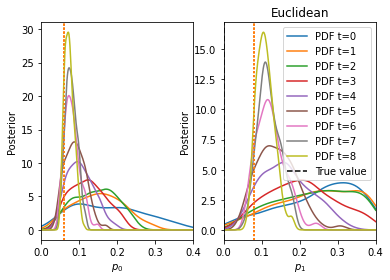

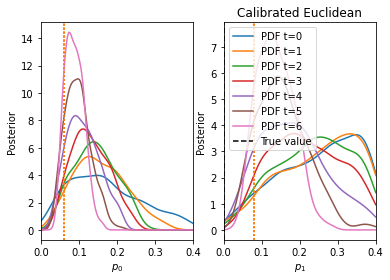

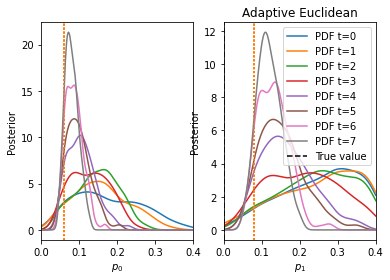

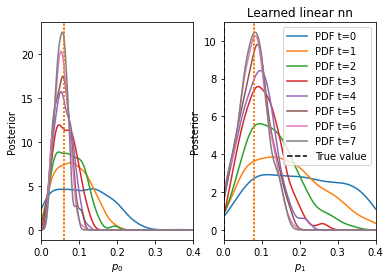

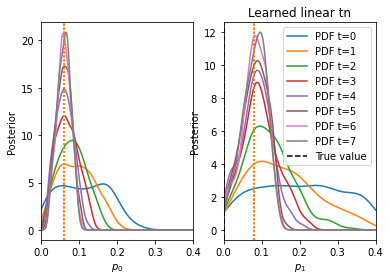

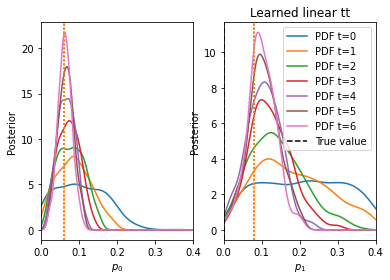

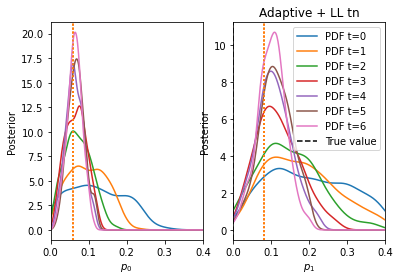

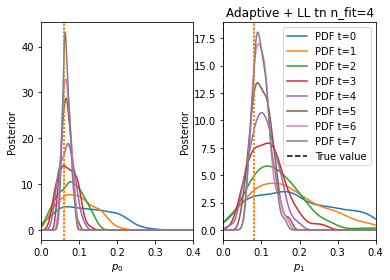

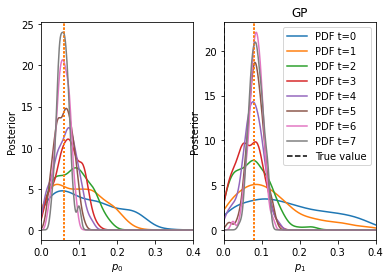

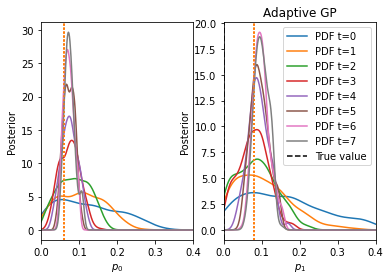

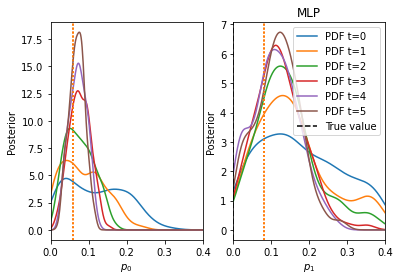

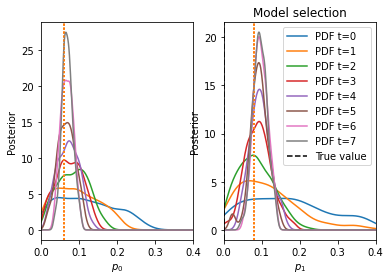

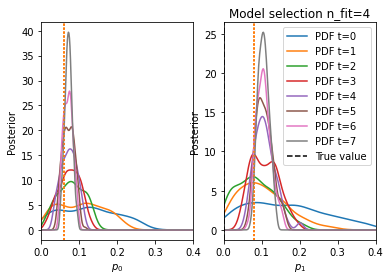

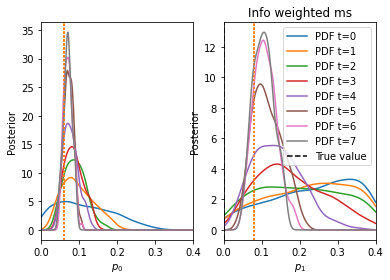

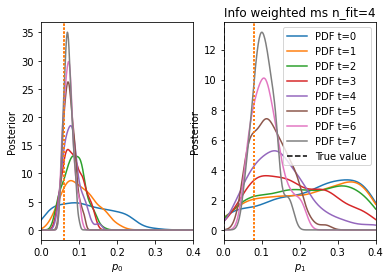

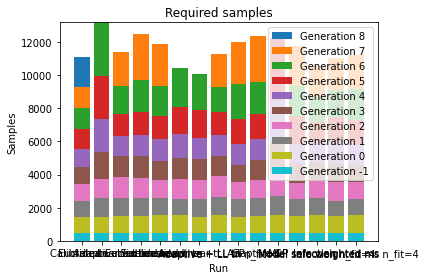

In [9]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)